In [28]:
#импорт библиотек
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import pickle

import sklearn
from sklearn import utils
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,mean_squared_error
from sklearn.model_selection import train_test_split

## Обработка полученного DataFrame

In [2]:
#загрузка DataFrame
file_path = os.path.join('..', 'data', 'reviews.csv')#путь к файлу
df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7246 entries, 0 to 7245
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review_id  7246 non-null   int64  
 1   date       5896 non-null   object 
 2   authority  7246 non-null   object 
 3   serv_name  7246 non-null   object 
 4   comment    7246 non-null   object 
 5   mscore     7246 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 339.8+ KB


Расшифровка полей DataFrame:

review_id - номер отзыва(по нему можно посмотреть заявление на сайте ВашКонтроль)

date - дата оставления отзыва

authority - орган валсти, оказывающий государственную услугу

serv_name - название государственной услуги

comment - кооментарий заявителя

mscore - средняя оценка обращения


В рамках проекта пердполагается, что отзывы оставленные со среденей оценкой равной 1 - негативные, а отзывы со средней оценкой 5 - позитивные

In [3]:
#формирование двух выборок данных
#негативная выборка
df_neg = df[df.mscore==1.0]

#позитивная выборка
df_poz = df[df.mscore==5.0]

#структура отобранных отзывов
df_neg.shape, df_poz.shape

((3623, 6), (3623, 6))

Если использовать парсер, будет наблюдаться дисбаланс классов со значительным смещением в сторону позитивных оценок, поэтому случайным образом возьмем количество позитивных отзывов, равное количеству негативных

In [4]:
#склеиваем таблицы и перемешиваем в случайном порядке
df_poz = df_poz.sample(n=df_neg.shape[0], random_state=42)
res_df = pd.concat([df_neg,df_poz])
res_df = sklearn.utils.shuffle(res_df)

#создание меток класса
res_df['y'] = res_df['mscore'].map({1.0:0,5.0:1})
res_df.head()

#исходный датасет для начала работы с текстом
dfm = res_df[['comment','y']]
dfm.head()

,comment,y
6258,"Отвратительный сайт, при вводе корректных данн...",0
1789,Пришло уведомление о выполнении услуги - резул...,0
2009,Специалист просто отказывает в предоставлении ...,0
5355,СПАСИБО ЗА ПОМОЩЬ В ОТПРАВКЕ ЗАЯВЛЕНИЯ. ОЧЕНЬ ...,1
1194,Все отлично,1


## Обработка текста комментариев

In [5]:
#функция для очистки текста
def preprocessing_text(text):
    text = text.lower().replace('ё', 'е')
    text = re.sub('((www\.[^\s]+)\|(https?://[^\s]+))', 'URL',text)
    text = re.sub('[^a-zA-Za-яА-Я]+',' ', text)
    text = re.sub(' +',' ', text)
    
    return text.strip()

#очистка текста
dfm = pd.DataFrame(data={'comment':dfm.comment.apply(lambda x : preprocessing_text(x)), 'y':dfm.y})
dfm.head()

,comment,y
6258,отвратительный сайт при вводе корректных данны...,0
1789,пришло уведомление о выполнении услуги результ...,0
2009,специалист просто отказывает в предоставлении ...,0
5355,спасибо за помощь в отправке заявления очень х...,1
1194,все отлично,1


## Перевод в векторное пространство

In [6]:
import torch
from transformers import AutoTokenizer, AutoModel

#функция для создания эмбеддингов
#здесь использовано уже готовое решение rubert-tiny(спасибо, cointegrated!):
#https://huggingface.co/cointegrated/rubert-tiny?text=Миниатюрная+модель+для+%5BMASK%5D+разных+задач.

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model, tokenizer).shape)
# (312,)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(312,)


In [7]:
#добавление эмбеддингов
dfm['X'] = dfm.comment.apply(lambda x : embed_bert_cls(x, model, tokenizer))
dfm.head()

#создание выборок для обучения
X = np.stack(dfm.X, axis=0 )
y = np.array(dfm.y)

#разделение выборок на тестовую и тренировочную
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=42)

## Выбор лучшего алгоритма классификации

### KNN

In [9]:
#импорт библиотек
from sklearn.neighbors import KNeighborsClassifier

#создание модели
nn = 9 #количестов соседей(опытным путем (по значениям score и msqe)найдено число оптимальное число 9 соседей на данном наборе данных)
knn = KNeighborsClassifier(nn).fit(X_train,y_train)
knn_pred = knn.predict(X_test)

In [10]:
knn.score(X_test,y_test)

0.9438822447102115

In [11]:
print(classification_report(y_test,knn_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1049
           1       0.94      0.95      0.95      1125

    accuracy                           0.94      2174
   macro avg       0.94      0.94      0.94      2174
weighted avg       0.94      0.94      0.94      2174



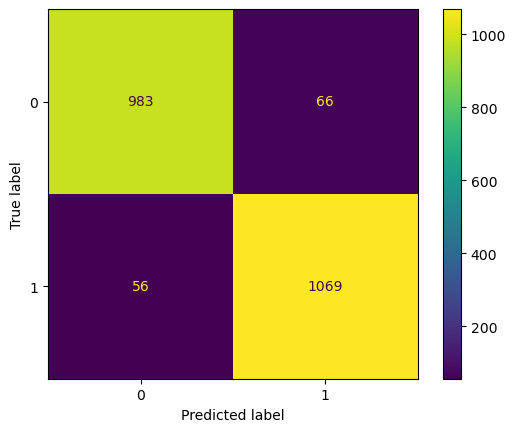

In [12]:
#confussion matrix
cm_knn = confusion_matrix(y_test,knn_pred)
cmd_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
cmd_knn.plot()

### Random Forest

In [13]:
# импорт библиотек
from sklearn.ensemble import RandomForestClassifier

#создание модели
rf = RandomForestClassifier(n_estimators=500,criterion='entropy',max_depth=30,random_state=42)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

In [14]:
rf.score(X_test,y_test)

0.9388224471021159

In [15]:
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1049
           1       0.96      0.92      0.94      1125

    accuracy                           0.94      2174
   macro avg       0.94      0.94      0.94      2174
weighted avg       0.94      0.94      0.94      2174



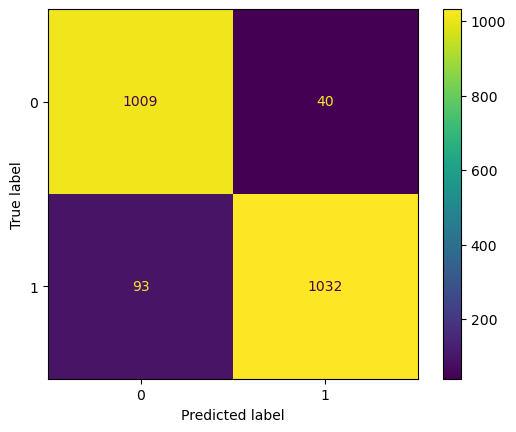

In [16]:
#confussion matrix
cm_rf = confusion_matrix(y_test,rf_pred)
cmd_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
cmd_rf.plot()

### SVM

In [17]:
#импорт библиотек
from sklearn import svm

#создание модели
svc = svm.SVC().fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [18]:
svc.score(X_test,y_test)

0.952161913523459

In [20]:
print(classification_report(y_test,svc_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1049
           1       0.97      0.94      0.95      1125

    accuracy                           0.95      2174
   macro avg       0.95      0.95      0.95      2174
weighted avg       0.95      0.95      0.95      2174



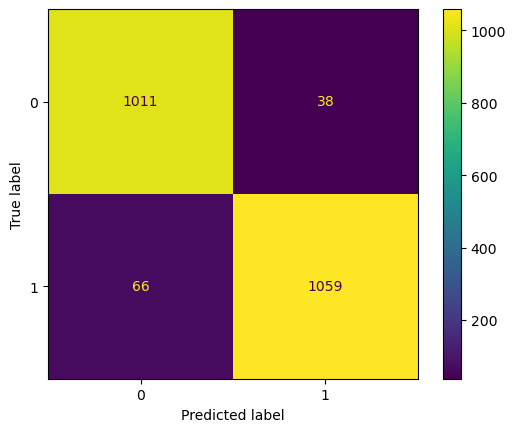

In [21]:
#confussion matrix
cm_svc = confusion_matrix(y_test,svc_pred)
cmd_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
cmd_svc.plot()

### Нейросеть

In [ ]:
#импорт библиотек
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense,concatenate,Activation,Dropout,Conv1D,SpatialDropout1D,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#Простая нейронная сеть
NNmodel = Sequential()
NNmodel.add(Dense(500,input_dim=X_train.shape[1],activation = 'relu'))
NNmodel.add(Dropout(0.2))
NNmodel.add(Dense(250,activation = 'relu'))
NNmodel.add(Dropout(0.2))
NNmodel.add(Dense(125,activation = 'relu'))
NNmodel.add(Dropout(0.2))
NNmodel.add(Dense(1,activation = 'sigmoid'))

In [23]:
NNmodel.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
NNmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               156500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               31375     
                                                                 
 dropout_2 (Dropout)         (None, 125)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               156500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               31375     
                                                                 
 dropout_2 (Dropout)         (None, 125)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

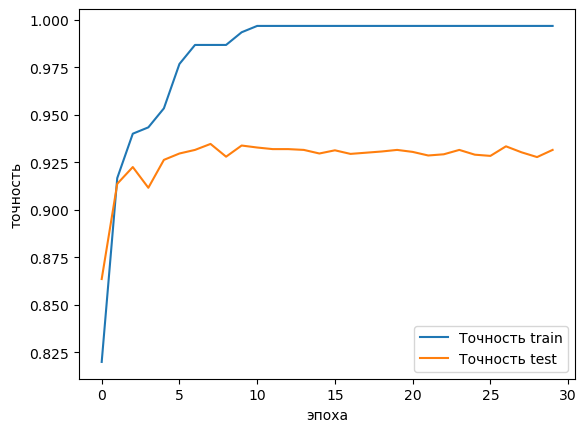

In [22]:
n = 300
history = NNmodel.fit(X_train[:n],y_train[:n],
                     batch_size=30,
                     epochs=30,
                     validation_data=(X_train[n:],y_train[n:]),
                     verbose=1)
plt.plot(history.history['accuracy'],label = 'Точность train')
plt.plot(history.history['val_accuracy'], label = "Точность test")
plt.xlabel('эпоха')
plt.ylabel('точность')
plt.legend()
plt.show()

## Выбор и сохранние модели

В целом, точность моделей находится приблизительно на одном уровне - 94%, поэтому выбор модели в текущих параметрах - дело вкуса. Для финальной реализации я выбрал KNN, хотя с тем же успехом мог выбрать и другие. Конечно, если занятся точной настройкой, можно повысить точность, но сейчас этого не требуется.

In [29]:
#сохранение модели через pickle
save_path = os.path.join('..','model','KNN_9_model.pkl')
knnPickle = open(save_path, 'wb') 
      
# сохранение
pickle.dump(knn, knnPickle)  

# закрытие файла
knnPickle.close()              
      
# загрузка моедли для проверки
loaded_knn_model = pickle.load(open(save_path, 'rb'))

#выгрузка требований
!pip freeze > requirements.txt